# Keck 2 Polarization Model

Here we create a model of the Keck 2 telescope + AO Bench to determine the transformation of the generally polarized field through the system. We've loaded a poke.Rayfront generated on a windows maching using a Zemax OpticStudio (ZOS) raytrace of the observatory.

In [51]:
from poke.writing import read_serial_to_rayfront
pth = 'rayfronts/k2_acam_64rays_633nm.msgpack'
rf = read_serial_to_rayfront(pth)

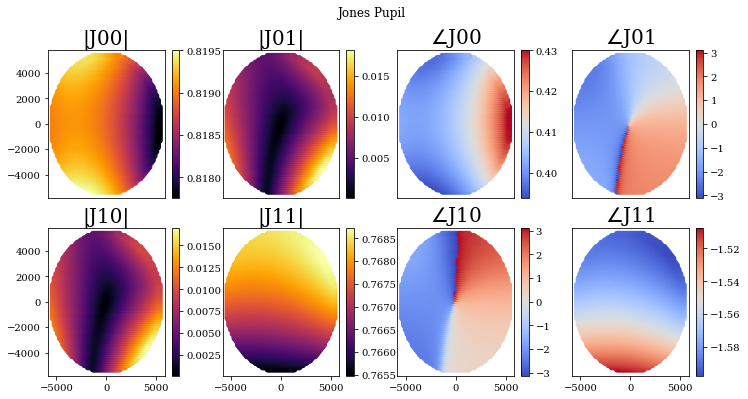

In [52]:
import poke.plotting as plot
plot.jones_pupil(rf)

## More realistic Coatings
I used a dummy coating of n = 0.4 + 7i on the prior coating just to generate something but we should model the observatory more realistically. What materials do we need?

**The Telescope**
- M1: https://www.keckobservatory.org/keeping_keck_telescopes_shiny/ claims that the primary mirror is aluminum, maybe it's a safe bet to just use Al for the observatory optics?

In [53]:
from poke.poke_math import np

# Jones pupil parameters for this raytrace
a = np.array([0.9781476007,-0.2079116908, 0.0000000000])
ap = np.array([0.9851019261,-0.1719714953, 0.0000000000]) # ray from edge of pupil
x = np.cross(a,ap)
x /= np.linalg.norm(x)

# lambda = 633nm
n_Al = 1.4495 + 1j*7.5387
n_Ag = 0.056206 + 1j*4.2776
n_ZD = 1.5403
n_SiO2 = 1.4570
n_MgF2 = 1.3770

al_coat = [(n_Ag,120e-9),(n_ZD)]
ag_coat = [(n_MgF2,54e-9),(n_Ag,120e-9),(n_ZD)]

# set up surfaces
m1 = {'coating':al_coat,'surf':1,'mode':'reflect'} # Al
m2 = {'coating':al_coat,'surf':2,'mode':'reflect'} # Al
m3 = {'coating':al_coat,'surf':4,'mode':'reflect'} # Al

k1 = {'coating':ag_coat,'surf':10,'mode':'reflect'} # Al
k2 = {'coating':ag_coat,'surf':13,'mode':'reflect'} # Opticoat protected silver or FSS99 Denton
k3 = {'coating':ag_coat,'surf':16,'mode':'reflect'} # Al

tt = {'coating':ag_coat,'surf':20,'mode':'reflect'} # remainder are Opticoat or FSS99 Denton
o1 = {'coating':ag_coat,'surf':25,'mode':'reflect'}
pu = {'coating':ag_coat,'surf':30,'mode':'reflect'}
o2 = {'coating':ag_coat,'surf':33,'mode':'reflect'}
di = {'coating':ag_coat,'surf':36,'mode':'reflect'}

sod = {'coating':ag_coat,'surf':40,'mode':'reflect'}
ifm = {'coating':ag_coat,'surf':43,'mode':'reflect'}
afm = {'coating':ag_coat,'surf':46,'mode':'reflect'}


rf.surfaces = [m1,m2,m3,k1,k2,k3,tt,o1,pu,o2,di,sod,ifm,afm]
# a = np.array([0.,0.,1.])
# x = np.array([1.,0.,0.])
rf.compute_jones_pupil(aloc=a,exit_x=x)

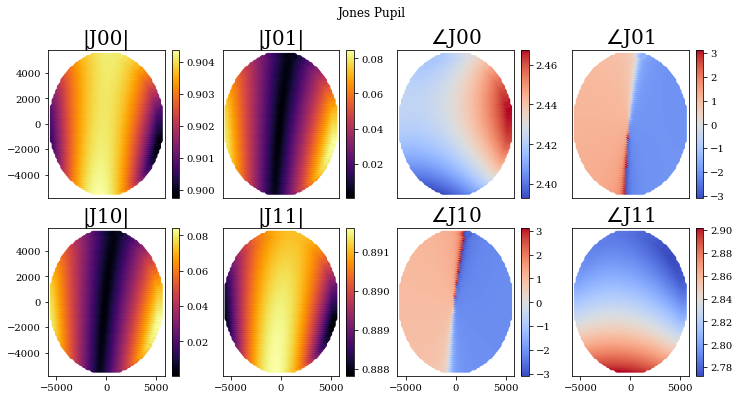

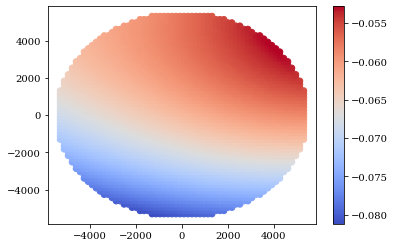

In [59]:
plot.jones_pupil(rf)
jones = rf.jones_pupil[-1][...,:2,:2]
from poke.poke_math import eigenvalues_2x2
evals = eigenvalues_2x2(jones)
ret = np.angle(evals[0]) - np.angle(evals[1])

plt.figure()
plt.scatter(xd,yd,c=ret/(2*np.pi),cmap='coolwarm')
plt.colorbar()
plt.show()

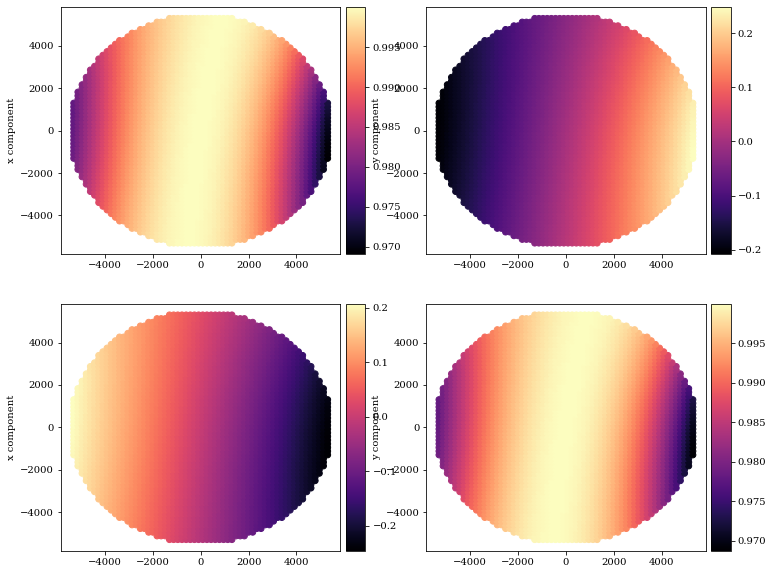

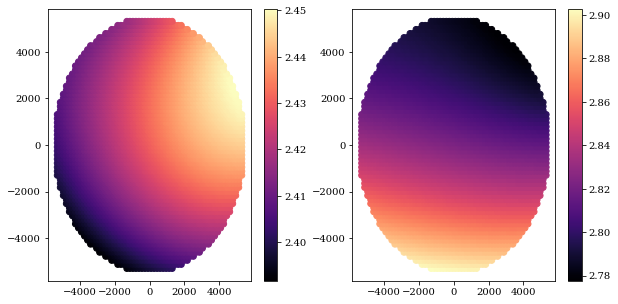

array([-0.66235345+0.61583322j, -0.66278865+0.61536116j,
       -0.66321073+0.61490133j, ..., -0.68331601+0.59206726j,
       -0.68383301+0.5914531j , -0.6843513 +0.59083467j])

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from poke.poke_math import eigenvalues_2x2
# get coords
xd,yd = rf.xData[0][0],rf.yData[0][0]

# Eigenpolarizations
jdata = rf.jones_pupil[-1][...,:2,:2]
# jdata = rf.P_total[-1][...,:2,:2]

evals,evecs = np.linalg.eig(jdata)
evals = eigenvalues_2x2(jdata)
lims = [
    [[0.97,1],[-.2,.2]],
    [[-.2,.2],[0.97,1]]
]

fig,axs = plt.subplots(ncols=2,nrows=2,figsize=[12,10])
for i in range(2):

    vmin,vmax = lims[i][0]
    im = axs[i,0].scatter(xd,yd,c=evecs[...,i,0],vmin=None,vmax=None)
    axs[i,0].set_ylabel('x component')
    div = make_axes_locatable(axs[i,0])
    cax = div.append_axes('right',size='7%',pad='2%')
    cb1 = fig.colorbar(im,cax=cax)

    vmin,vmax = lims[i][1]
    im = axs[i,1].scatter(xd,yd,c=evecs[...,i,1],vmin=None,vmax=None)
    axs[i,1].set_ylabel('y component')
    div = make_axes_locatable(axs[i,1])
    cax = div.append_axes('right',size='7%',pad='2%')
    cb2 = fig.colorbar(im,cax=cax)
op = np.angle
plt.show()
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.scatter(xd,yd,c=op(evals[0]))
plt.colorbar()
plt.subplot(122)
plt.scatter(xd,yd,c=op(evals[1]))
plt.colorbar()
plt.show()
evals[0]

(3096, 2)
3096


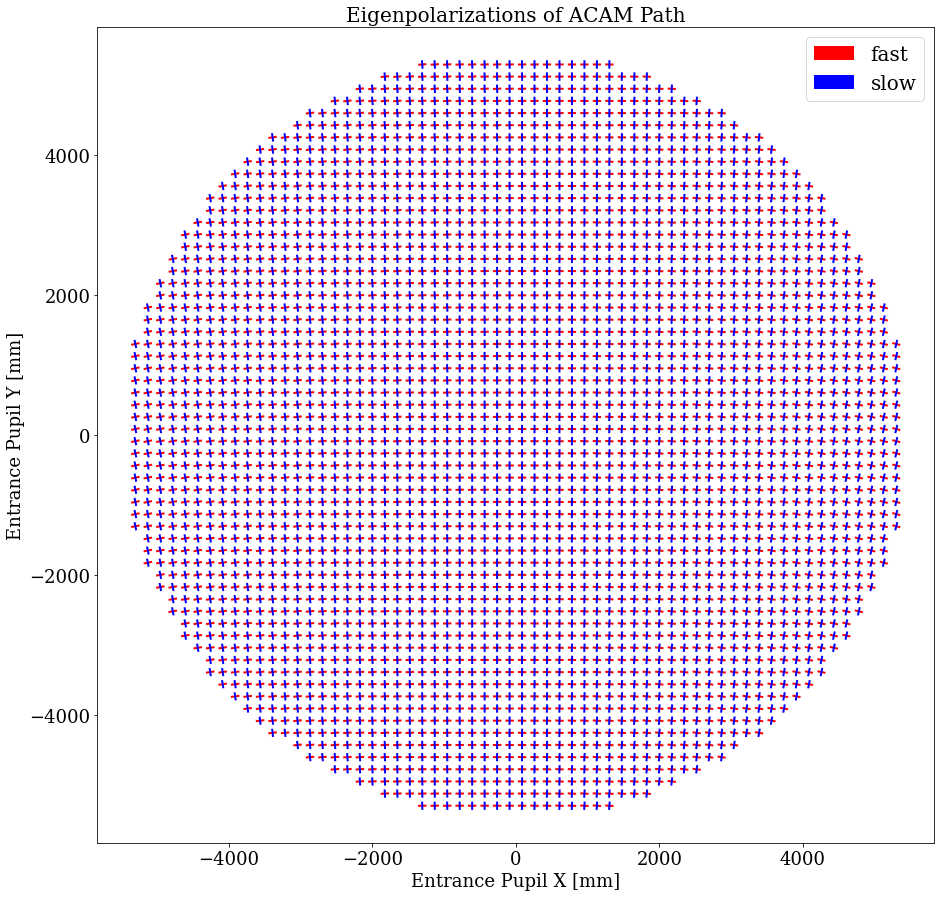

In [56]:
# plot the mean eigenpolarizations
mean_1_x = np.mean(evecs[...,0,0])
mean_1_y = np.mean(evecs[...,0,1])
mean_2_x = np.mean(evecs[...,1,0])
mean_2_y = np.mean(evecs[...,1,1])

slow = np.zeros_like(evecs[...,0])
fast = np.zeros_like(evecs[...,0])
print(fast.shape)
i = 0
# sorting the polarizations by eigenvalue
for v1,e1,v2,e2 in zip(evecs[...,0],evals[0],evecs[...,1],evals[1]):

    if np.angle(e1) > np.angle(e2):
        slow[i] = v1
        fast[i] = v2
    else:
        slow[i] = v2
        fast[i] = v1

    i += 1

print(i)
scale_off = 1

fig,ax = plt.subplots(figsize=[15,15])
plt.title('Eigenpolarizations of ACAM Path')
# plt.quiver(0,0,mean_1_x,mean_1_y*100,color='red')
ax.quiver(xd,yd,fast[...,0],fast[...,1],color='red',headwidth=1,headlength=0,label='fast',pivot='mid')
ax.quiver(xd,yd,slow[...,0],slow[...,1],color='blue',headwidth=1,headlength=0,label='slow',pivot='mid')
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=20)
# plt.quiver(0,0,mean_2_x,mean_2_y,color='blue')
plt.xlabel('Entrance Pupil X [mm]',fontsize=18)
plt.ylabel('Entrance Pupil Y [mm]',fontsize=18)
plt.show()


## PSF Analysis
Let's get hexagonal

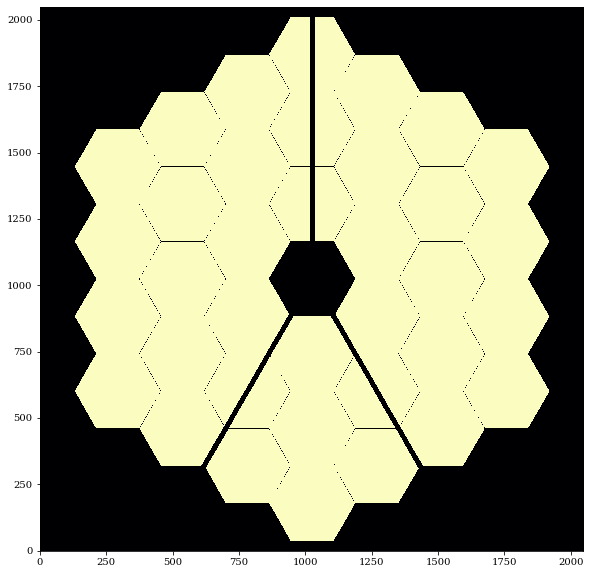

In [7]:
from prysm import (
    coordinates,
    geometry,
    segmented,
    polynomials,
    propagation,
    wavelengths
)
import matplotlib.pyplot as plt

x, y = coordinates.make_xy_grid(2048, diameter=10.950)
dx = x[0,1] - x[0,0]

cha = segmented.CompositeHexagonalAperture(x,y,3,1.5,0.007,exclude=(0,))
m1 = geometry.spider(1, .1, x, y, rotation=-120)
m2 = geometry.spider(1, .1, x, y, rotation=-60)
m3 = geometry.spider(1, .1, x, y, rotation=90)
spider = m1&m2&m3

pupil_mask = cha.amp & spider
plt.figure(figsize=[10,10])
plt.imshow(pupil_mask)
plt.show()

[4.95202366e-08]
[5.55247786e-08]
[7.53764505e-08]
[8.42712997e-08]


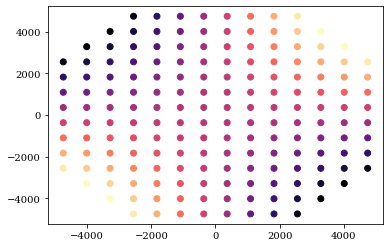

In [8]:
# Fit the jones pupil data to zernike polynomials
xd,yd = rf.xData[0,0],rf.yData[0,0]
r,t = np.sqrt(xd**2 + yd**2),np.arctan2(yd,xd)
nms = [polynomials.noll_to_nm(j) for j in range(1,11)]
modes = (list(polynomials.zernike_nm_sequence(nms,r,t)))
modes = np.array([mode for mode in modes])
plt.scatter(xd,yd,c=modes[4])

def make_jones_functional(jones_pupil,modes):

    c = np.linalg.lstsq(modes.T,jones_pupil,rcond=None)
    print(c[1])

    return c[0]
which = -1
cxx = make_jones_functional(rf.jones_pupil[which][...,0,0],modes)
cxy = make_jones_functional(rf.jones_pupil[which][...,0,1],modes)
cyx = make_jones_functional(rf.jones_pupil[which][...,1,0],modes)
cyy = make_jones_functional(rf.jones_pupil[which][...,1,1],modes)

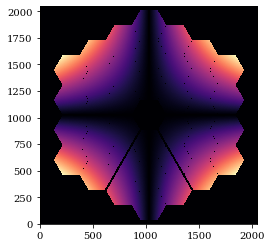

In [9]:
rs,ts = coordinates.cart_to_polar(x,y)
modes_reg = np.complex128(list(polynomials.zernike_nm_sequence(nms,rs,ts)))
plt.imshow(np.abs(modes_reg[4]*pupil_mask))

<ipython-input-10-822e3910e5ad>:9: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.angle(jyy)*A/A,cmap='coolwarm')


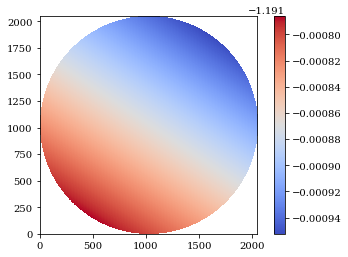

In [10]:
A = geometry.circle(10.95/2,rs)

# Now fit to the data
jxx = polynomials.sum_of_2d_modes(modes_reg,cxx)
jxy = polynomials.sum_of_2d_modes(modes_reg,cxy)
jyx = polynomials.sum_of_2d_modes(modes_reg,cyx)
jyy = polynomials.sum_of_2d_modes(modes_reg,cyy)
plt.figure()
plt.imshow(np.angle(jyy)*A/A,cmap='coolwarm')
plt.colorbar()